In [1]:
"""
=================
Shot freeze frame
=================

This example shows how to plot a shot freeze frame.
shot.outcome.id
"""

from mplsoccer.pitch import VerticalPitch
from mplsoccer.utils import add_image
from mplsoccer.statsbomb import read_event, read_lineup, EVENT_SLUG, LINEUP_SLUG
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'
cwd = os.getcwd()

# get event and lineup dataframes for game 7478

# event data
dict_event = read_event(f'{EVENT_SLUG}/18245.json', related_event_df=False, tactics_lineup_df=False, warn=False)
df_event = dict_event['event']
df_freeze = dict_event['shot_freeze_frame']

# lineup data
df_lineup = read_lineup(f'{LINEUP_SLUG}/18245.json', warn=False)
df_lineup = df_lineup[['player_id', 'player_jersey_number', 'team_name']].copy()

##############################################################################
# Subset a shot

shot_id = '7654fe57-734f-45d8-bc83-ab940cd37c45'
df_freeze_frame = df_freeze[df_freeze.id==shot_id].copy()
df_shot_event = df_event[df_event.id==shot_id].dropna(axis=1, how='all').copy()

# add the jersey number
df_freeze_frame = df_freeze_frame.merge(df_lineup, how='left', on='player_id')

##############################################################################
# Subset the teams

# strings for team names
team1 = df_shot_event.team_name.iloc[0]
team2 = list(set(df_event.team_name.unique()) - set([team1]))[0]

# subset the team shooting, and the opposition (goalkeeper/ other)
df_team1 = df_freeze_frame[df_freeze_frame.team_name == team1]
df_team2_goal = df_freeze_frame[(df_freeze_frame.team_name == team2) & 
                                 (df_freeze_frame.player_position_name == 'Goalkeeper')]
df_team2_other = df_freeze_frame[(df_freeze_frame.team_name == team2) & 
                                 (df_freeze_frame.player_position_name != 'Goalkeeper')]

In [2]:
logo = np.array(Image.open('SB_Regular.png'))

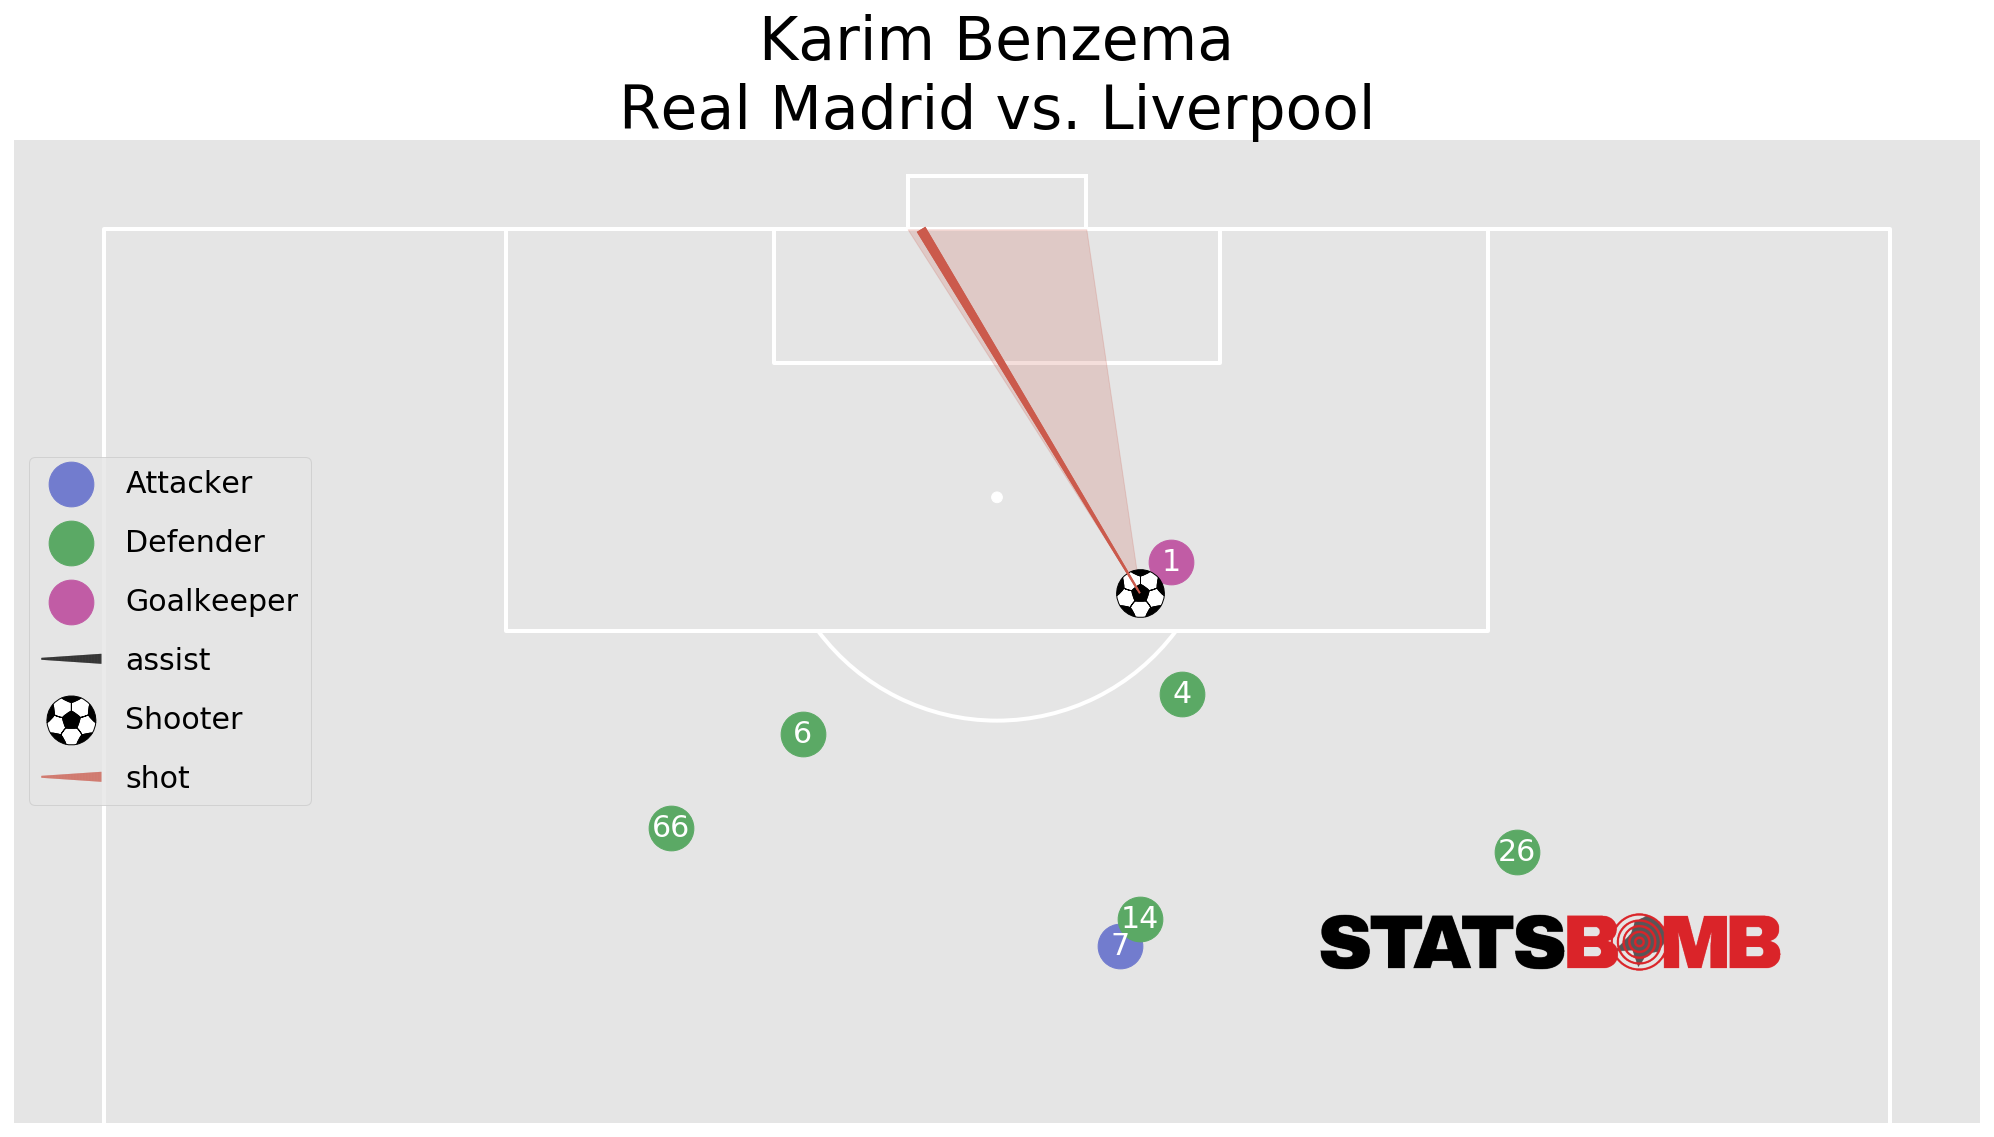

In [3]:
# Setup the pitch
figsize = (16, 8)
pitch = VerticalPitch(half=True, tight_layout=False, goal_type='box', pad_bottom=-20)
fig, ax = pitch.draw(figsize=figsize)

assist_pass = df_event.loc[df_event.id=='ec4b9535-f627-49b0-a0c5-cc82b51c582e', ['x', 'y', 'end_x', 'end_y']]

# Plot the players
sc1 = pitch.scatter(df_team1.x, df_team1.y, s=500, c='#727cce', label='Attacker', ax=ax)
sc2 = pitch.scatter(df_team2_other.x, df_team2_other.y, s=500, c='#5ba965', label='Defender', ax=ax)
sc4 = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=500, ax=ax, c='#c15ca5', label='Goalkeeper')
pitch.lines(assist_pass.x, assist_pass.y, assist_pass.end_x, assist_pass.end_y,
            comet=True, label='assist', color='black', ax=ax)

# plot the shot
sc3 = pitch.scatter(df_shot_event.x, df_shot_event.y, marker='football', s=600, ax=ax, label='Shooter', zorder=1.2)
line = pitch.lines(df_shot_event.x, df_shot_event.y, 
                   df_shot_event.end_x, df_shot_event.end_y, comet=True, label='shot', color='#cb5a4c', ax=ax)

# plot the angle to the goal
pitch.goal_angle(df_shot_event.x, df_shot_event.y, ax=ax, alpha=0.2, zorder=1.1, color='#cb5a4c', goal='right')

# plot the jersey numbers
for i, label in enumerate(df_freeze_frame.player_jersey_number):
    pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
                   va='center', ha='center', color='white', fontsize=15, ax=ax)

# add a legend and title 
legend = ax.legend(loc='center left', labelspacing=1, fontsize=15)
title = ax.set_title(f'{df_shot_event.player_name.iloc[0]}\n{team1} vs. {team2}', fontsize=30)
ax_image1 = add_image(logo, fig, left=0.64, bottom=0.15, width=0.2, alpha=1, interpolation='hanning')
fig.savefig(os.path.join(cwd, 'figures', '04_freeze_frame_example.png'), bbox_inches = 'tight', pad_inches = 0)